## IMPORTING ALL THE NECESSARY PACKAGES

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Multiply
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.callbacks import ModelCheckpoint
import argparse

## BUILDING OUR WORKING MODEL

In [2]:
def build_model(im_shape, vocab_size, num_answers):
  #The CNN model
  im_input = Input(shape=im_shape)
  x1 = Conv2D(8, 3, padding='same')(im_input)
  x1 = MaxPooling2D()(x1)
  x1 = Conv2D(16, 3, padding='same')(x1)
  x1 = MaxPooling2D()(x1)
  x1 = Flatten()(x1)
  # Adding two fully-connected layers after the CNN for good measure
  x1 = Dense(32, activation='tanh')(x1)
  x1 = Dense(32, activation='tanh')(x1)
  
  # A simple question network formed by three fully-connected layers
  q_input = Input(shape=(vocab_size,))
  x2 = Dense(32, activation='tanh')(q_input)
  x2 = Dense(32, activation='tanh')(x2)
  x2 = Dense(32, activation='tanh')(x2)

  # The processed image and the processed question is merged
  out = Multiply()([x1, x2])
  out = Dense(32, activation='tanh')(out)
  out = Dense(32, activation='tanh')(out)
  out = Dense(num_answers, activation='softmax')(out)

  model = Model(inputs=[im_input, q_input], outputs=out)
  model.compile(Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## GETTING THE FREQUENCY OF EACH ANSWER IN THE DATASET

Text(0.5, 0, 'Frequency of answers')

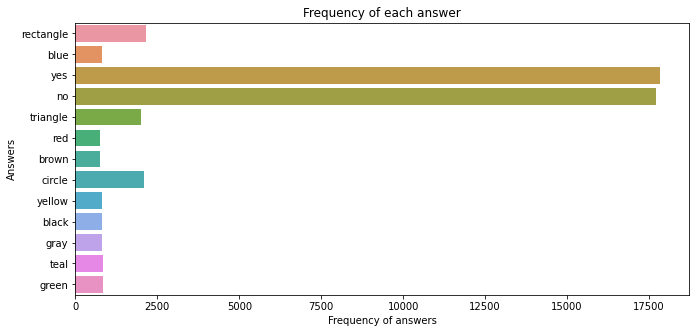

In [3]:
def read_questions(path):
      with open(path, 'r') as file:
        qs = json.load(file)
      ques = [q[0] for q in qs]
      ans = [q[1] for q in qs]
      image_ids = [q[2] for q in qs]
      return (ques, ans, image_ids)
    
train_qs, train_ans, train_image_ids = read_questions('data/train/questions.json')
valid_qs, valid_ans, valid_image_ids = read_questions('data/validation/questions.json')
test_qs, test_ans, test_image_ids = read_questions('data/test/questions.json')

ans_tot=train_ans+valid_ans+test_ans
plt.figure(figsize=(11,5))
plt.title("Frequency of each answer")
plt.ylabel("Answers")
sns.countplot(y=ans_tot)
plt.xlabel("Frequency of answers")

## DATA PREPROCESSING

In [4]:
def setup(use_data_dir):
    print('\n--- Reading questions...')
    # Read data from data/ folder
    def read_questions(path):
      with open(path, 'r') as file:
        qs = json.load(file)
      texts = [q[0] for q in qs]
      answers = [q[1] for q in qs]
      image_ids = [q[2] for q in qs]
      return (texts, answers, image_ids)
    
    train_qs, train_answers, train_image_ids = read_questions('data/train/questions.json')
    valid_qs, valid_answers, valid_image_ids = read_questions('data/validation/questions.json')
    test_qs, test_answers, test_image_ids = read_questions('data/test/questions.json')
  
    print(f'Read {len(train_qs)} training questions, {len(valid_qs)} validation questions and {len(test_qs)} testing questions.')

    print('\n--- Reading answers...')
    # Read answers from data/ folder
    with open('data/answers.txt', 'r') as file:
        all_answers = [a.strip() for a in file]
    
    num_answers = len(all_answers)
    print(f'Found {num_answers} total answers:')
    print(all_answers)

    print('\n--- Reading/processing images...')
    def load_and_proccess_image(image_path):
        # Load image, then scale and shift pixel values to [-0.5, 0.5]
        im = img_to_array(load_img(image_path))
        return im / 255 - 0.5

    def read_images(paths):
        # paths is a dict mapping image ID to image path
        # Returns a dict mapping image ID to the processed image
        ims = {}
        for image_id, image_path in paths.items():
            ims[image_id] = load_and_proccess_image(image_path)
        return ims

    # Read images from data/ folder
    def extract_paths(dir):
        paths = {}
        for filename in os.listdir(dir):
            if filename.endswith('.png'):
                image_id = int(filename[:-4])
                paths[image_id] = os.path.join(dir, filename)
        return paths

    train_ims = read_images(extract_paths('data/train/images'))
    valid_ims = read_images(extract_paths('data/validation/images'))
    test_ims  = read_images(extract_paths('data/test/images'))
  
    im_shape = train_ims[0].shape
    print(f'Read {len(train_ims)} training images, {len(valid_ims)} validation images and {len(test_ims)} testing images.')
    print(f'Each image has shape {im_shape}.')


    print('\n--- Fitting question tokenizer...')
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_qs)

    # We add one because the Keras Tokenizer reserves index 0 and never uses it.
    vocab_size = len(tokenizer.word_index) + 1
    print(f'Vocab Size: {vocab_size}')
    print(tokenizer.word_index)


    print('\n--- Converting questions to bags of words...')
    train_X_seqs = tokenizer.texts_to_matrix(train_qs)
    valid_X_seqs = tokenizer.texts_to_matrix(valid_qs)
    test_X_seqs = tokenizer.texts_to_matrix(test_qs)
    print(f'Example question bag of words: {train_X_seqs[0]}')


    print('\n--- Creating model input images...')
    train_X_ims = np.array([train_ims[id] for id in train_image_ids])
    valid_X_ims = np.array([valid_ims[id] for id in valid_image_ids])
    test_X_ims = np.array([test_ims[id] for id in test_image_ids])


    print('\n--- Creating model outputs...')
    train_answer_indices = [all_answers.index(a) for a in train_answers]
    valid_answer_indices = [all_answers.index(a) for a in valid_answers]
    test_answer_indices = [all_answers.index(a) for a in test_answers]
  
    train_Y = to_categorical(train_answer_indices)
    valid_Y = to_categorical(valid_answer_indices)
    test_Y = to_categorical(test_answer_indices)
    print(f'Example model output: {train_Y[0]}')

    return (train_X_ims, train_X_seqs, train_Y, test_X_ims, test_X_seqs,
          test_Y, im_shape, vocab_size, num_answers,
          all_answers, test_qs, test_answer_indices, valid_X_ims, valid_X_seqs, valid_Y)

## TRAINING OUR MODEL HERE

In [5]:
# Support command-line options
parser = argparse.ArgumentParser()
parser.add_argument('--use-data-dir', action='store_true', help='Use custom data directory, at /data')
parser.add_argument('-f')
args = parser.parse_args()

if args.use_data_dir:
  print('Using data directory')

# Prepare data
train_X_ims, train_X_seqs, train_Y, test_X_ims, test_X_seqs, test_Y, im_shape, vocab_size, num_answers, _, _, _, valid_X_ims, valid_X_seqs, valid_Y = setup(args.use_data_dir)

print('\n--- Building model...')
model = build_model(im_shape, vocab_size, num_answers)
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

print('\n--- Training model...')
Hist=model.fit(
  [train_X_ims, train_X_seqs],
  train_Y,
  validation_data=([valid_X_ims, valid_X_seqs], valid_Y),
  shuffle=True,
  epochs=15,
  callbacks=[checkpoint],
)


--- Reading questions...
Read 28833 training questions, 9742 validation questions and 9673 testing questions.

--- Reading answers...
Found 13 total answers:
['circle', 'green', 'red', 'gray', 'yes', 'teal', 'black', 'rectangle', 'yellow', 'triangle', 'brown', 'blue', 'no']

--- Reading/processing images...
Read 3000 training images, 1000 validation images and 1000 testing images.
Each image has shape (64, 64, 3).

--- Fitting question tokenizer...
Vocab Size: 27
{'is': 1, 'shape': 2, 'the': 3, 'a': 4, 'image': 5, 'there': 6, 'not': 7, 'what': 8, 'present': 9, 'does': 10, 'contain': 11, 'in': 12, 'color': 13, 'no': 14, 'rectangle': 15, 'circle': 16, 'triangle': 17, 'brown': 18, 'yellow': 19, 'gray': 20, 'teal': 21, 'green': 22, 'black': 23, 'blue': 24, 'red': 25, 'of': 26}

--- Converting questions to bags of words...
Example question bag of words: [0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0.]

--- Creating model input images...

--- Creating mode

c:\users\sawan aich\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


902/902 [==============================] - 20s 22ms/step - loss: 0.7620 - accuracy: 0.6642 - val_loss: 0.7621 - val_accuracy: 0.6617
Epoch 3/15
902/902 [==============================] - 20s 22ms/step - loss: 0.7545 - accuracy: 0.6667 - val_loss: 0.7280 - val_accuracy: 0.6805
Epoch 4/15
902/902 [==============================] - 20s 22ms/step - loss: 0.6791 - accuracy: 0.6968 - val_loss: 0.6321 - val_accuracy: 0.7050
Epoch 5/15
902/902 [==============================] - 20s 22ms/step - loss: 0.5792 - accuracy: 0.7268 - val_loss: 0.5567 - val_accuracy: 0.7254
Epoch 6/15
902/902 [==============================] - 20s 23ms/step - loss: 0.5089 - accuracy: 0.7537 - val_loss: 0.4949 - val_accuracy: 0.7499
Epoch 7/15
902/902 [==============================] - 20s 22ms/step - loss: 0.4432 - accuracy: 0.7757 - val_loss: 0.4428 - val_accuracy: 0.7728
Epoch 8/15
902/902 [==============================] - 20s 23ms/step - loss: 0.3862 - accuracy: 0.8066 - val_loss: 0.4079 - val_accuracy: 0.8039
Epo

## LOADING THE SAVED MODEL

In [10]:
from tensorflow.keras.models import load_model
model1=load_model(r'./model.h5')

## SHOWING THE PLOTS FOR LOSS AND ACCURACY

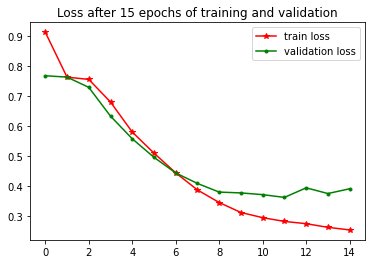

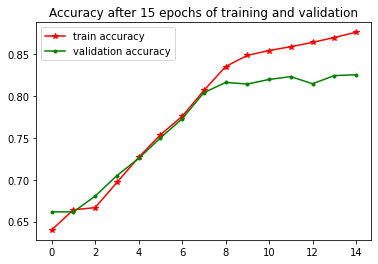

In [6]:
plt.plot(Hist.history['loss'],"r*-",label="train loss")
plt.plot(Hist.history['val_loss'],"g.-",label="validation loss")
plt.legend()
plt.title("Loss after 15 epochs of training and validation")
plt.show()
plt.plot(Hist.history['accuracy'],"r*-",label="train accuracy")
plt.plot(Hist.history['val_accuracy'],"g.-",label="validation accuracy")
plt.legend()
plt.title("Accuracy after 15 epochs of training and validation")
plt.show()

## ACTUAL CODE FOR PREDICTION STARTS HERE

In [12]:
def predict(image):
    
    with open('data/answers.txt', 'r') as file:
        all_answers = [a.strip() for a in file]
    
    def read_questions(path):
        with open(path, 'r') as file:
            qs = json.load(file)
        texts = [q[0] for q in qs]
        answers = [q[1] for q in qs]
        image_ids = [q[2] for q in qs]
        return (texts, answers, image_ids)

    test_qs, test_answers, test_image_ids = read_questions('data/test/questions.json')

    #print('\n--- Reading/processing images...')
    def load_and_proccess_image(image_path):
        # Load image, then scale and shift pixel values to [-0.5, 0.5]
        im = img_to_array(load_img(image_path))
        return im / 255 - 0.5

    def read_images(paths):
        # paths is a dict mapping image ID to image path
        # Returns a dict mapping image ID to the processed image
        ims = {}
        for image_id, image_path in paths.items():
            ims[image_id] = load_and_proccess_image(image_path)
        return ims

    # Read images from data/ folder
    def extract_paths(dir):
        paths = {}
        for filename in os.listdir(dir):
            if filename.endswith('.png'):
                image_id = int(filename[:-4])
                paths[image_id] = os.path.join(dir, filename)
        return paths

    test_ims  = read_images(extract_paths('data/test/images'))

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(test_qs)

    # We add one because the Keras Tokenizer reserves index 0 and never uses it.
    vocab_size = len(tokenizer.word_index) + 1

    #print('\n--- Converting questions to bags of words...')
    test_X_seqs = tokenizer.texts_to_matrix(test_qs)

    #print('\n--- Creating model input images...')
    test_X_ims = np.array([test_ims[id] for id in test_image_ids])
    
    #storing all the answers in an array form
    ans=np.array(all_answers)

    #storing all the question indexes where that particular image has been found
    ind=np.where(np.array(test_image_ids)==int(image[:-4]))
    
    #getting the final image and resizing it for making it compatible
    final_testing_image = test_X_ims[ind[0][0]]
    final_test_im = final_testing_image.reshape((1,64,64,3))
    
    #core prediction part starts here
    print("If you want to ask a question from a pre-defined set of questions, enter 1")
    print("If you want to ask a question on your own, enter 2")
    choice = int(input("Enter your value here : "))
    
    if choice == 1:
    
        #showing all possible questions related to the randomly generated image
        print("Pre-defined questions related to this image are as follows :")
        df=pd.DataFrame(np.array(test_qs)[ind],columns=["Questions"])
        print(df)
        num=int(input("Enter a question index : "))

        final_testing_qs = test_X_seqs[ind[0][0] + num]
        final_test_qs = final_testing_qs.reshape((1,27))
                
    elif choice == 2:
        
        final_testing_qs= input("Enter your question here : ")
        #print('\n--- Converting questions to bags of words...')
        final_test_qs = tokenizer.texts_to_matrix([final_testing_qs])
        
    else:
        return "WRONG CHOICE!! TRY AGAIN"
        
    #final prediction to be done
    final_output = model1.predict([final_test_im, final_test_qs])
    max_outputs=np.sort(final_output[0])[-3:][::-1]
    indices=np.argsort(final_output[0])[-3:][::-1]
    final_answer=ans[[i for i in indices]]
    
    #plotting top 3 probable answers for the asked question
    top_outputs = sns.barplot(x=max_outputs*100,y=final_answer)
    
    #can be implemented using a loop as per number of outputs
    top_outputs.annotate(round(max_outputs[0]*100,2),xy=(max_outputs[0]*100-10,0))
    top_outputs.annotate(round(max_outputs[1]*100,2),xy=(max_outputs[1]*100,1))
    top_outputs.annotate(round(max_outputs[2]*100,2),xy=(max_outputs[2]*100,2))
    
    plt.title("Predicted top 3 answers with confidence")
    plt.xlabel("Confidence (in %)", size=14)
    plt.ylabel("Probable Answers", size=14)
    
    
    return top_outputs

## TESTING ON A RANDOMLY GENERATED IMAGE FROM THE TEST SET

Text(0.5, 1.0, 'Test Image')

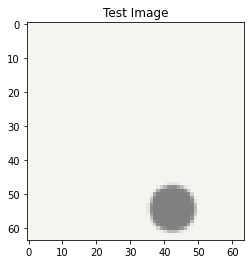

In [18]:
import random, os
import matplotlib.pyplot as plt
from PIL import Image

path = r'data/test/images'
random_filename = random.choice([
    x for x in os.listdir(path)
    if os.path.isfile(os.path.join(path, x))
])
random_filename
im = Image.open(path+'/'+random_filename)
plt.imshow(im)
plt.title("Test Image")

## PREDICTING THE ANSWER HERE

If you want to ask a question from a pre-defined set of questions, enter 1
If you want to ask a question on your own, enter 2
Enter your value here : 1
Pre-defined questions related to this image are as follows :
                                Questions
0             what shape is in the image?
1               what color is the circle?
2        what is the color of the circle?
3                what color is the shape?
4                   is there a rectangle?
5  is there not a rectangle in the image?
6                    is there a triangle?
7    is there a black shape in the image?
8              is no green shape present?
9               is no blue shape present?
Enter a question index : 7
AxesSubplot(0.125,0.125;0.775x0.755)


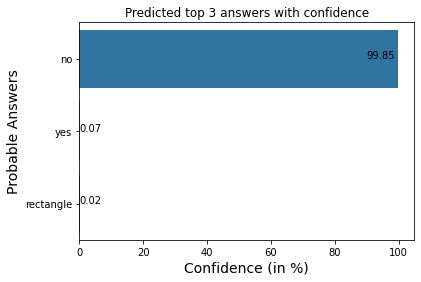

In [22]:
prediction=predict(random_filename)
# print("Predicted top 3 answers with confidence : ")
print(prediction)